In [2]:
# Wgranie odpowiednich bibliotek
import numpy as np
import math
from scipy import signal
from scipy import fft 
import seaborn as sns
import cmath as cm
import matplotlib.pyplot as plt
from matplotlib import cm as mpl
from mpl_toolkits import mplot3d
import random

0.010124221364710936
-19.94638367620715


Text(0, 0.5, 'amplituda [a.u.]')

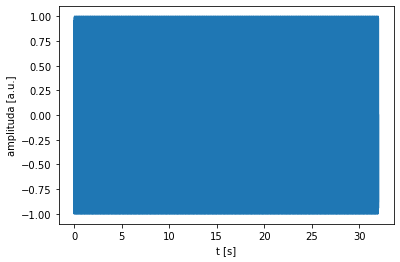

In [89]:
# Deklaracja parametrów algorytmu
N = 128 * 128
NN = 128 # NN odpowiada zmiennej N'
L = 32
P = int((N-NN)/L) 

# Deklaracja przykładowych sygnałów:
# x=y stanowią modulację sinusoidalną pozbawioną szumów

samplingFreq = 512
timeRange = N/samplingFreq 
timeLine = np.linspace(0, timeRange, N) # oś czasu w s
f = 100 # częstotliwość sygnału podana w Hz
x = np.sin(timeLine *2*np.pi * f)

noise = np.random.normal(0, 7, x.shape) 

SNR = np.mean(np.square(x))/np.mean(np.square(noise))
print(SNR)
print(10*np.log10(SNR))
x = x #+ noise

y = x

# wizualizacja sygnału
plt.plot(timeLine,x)
plt.xlabel('t [s]')
plt.ylabel('amplituda [a.u.]')

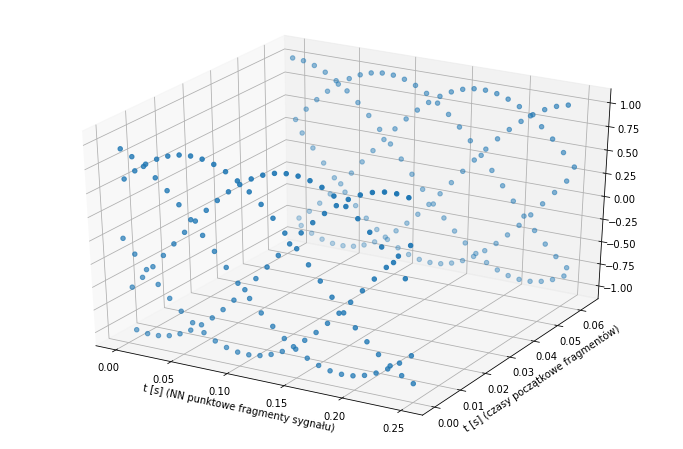

In [90]:
# Formatowanie sygnałów
# Dane sygnału x zapisywane są w dwuwymiarowej tablicy CHx[p][n]
# p=0,1,...,P-1 numeruje fragmenty wydzielone z tablicy x
# n=0,1,...,NN-1 numeruje elementy w obrębie pojedynczego fragmentu

CHx = [ [ x[ p*L + k ] for k in range(NN) ] for p in range(P) ] 
CHy = [ [ y[ p*L + k ] for k in range(NN) ] for p in range(P) ] 

# wizualizacja CHx dla początkowych indeksów p=0,1
fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
X = np.linspace(0, NN/samplingFreq, NN) # [s], skala czasu poszczególnych fragmentów sygnału
Y = np.linspace(0, timeRange, P) # [s], Y wyznacza początki kolejnych bloków NN punktowych
X, Y = np.meshgrid(X,Y)
CHx = np.array(CHx) 
ax.scatter(X[:2],Y[:2],CHx[:2])
ax.set_xlabel('t [s] (NN punktowe fragmenty sygnału)')
ax.set_ylabel('t [s] (czasy początkowe fragmentów)')
fig.set_figwidth(12)
fig.set_figheight(8)

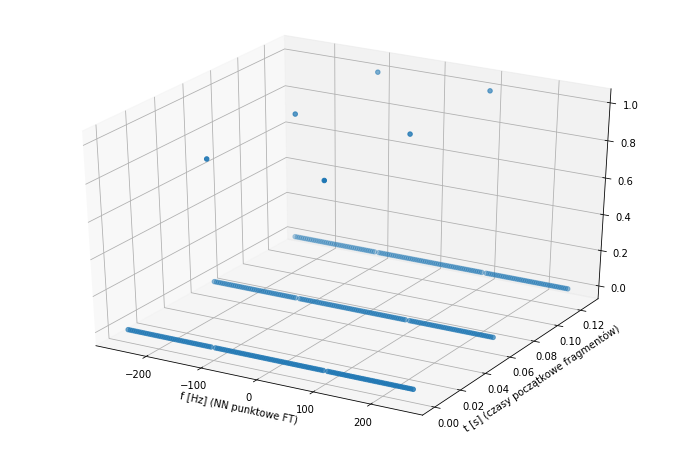

In [91]:
# NN-elementowe FFT
# dla wygody zastosowano normalizację 1/NN już na tym etapie

CHX = [ fft(CHx[p])/NN for p in range(P) ]
CHY = [ fft(CHy)[p]/NN for p in range(P) ]

# Wizualizacja zespolonej transformaty Fouriera może zostać zastąpiona
# przez wizualizację widma dla początkowych indeksów p=0,1,2
# ze wzgledu na fakt, że sygnał x jest rzeczywisty -> X(-f) = X(f)
# widmo oblicza się na podstawie dwukrotności transformaty Fouriera
CHXpsd = [ np.power(2*abs(CHX[k]),2) for k in range(P) ]

# zdefiniowanie osi częstotliwości NN-elementowej transformaty Fouriera
# w efekcie: CHX[k] = X(f[k])
freq1 = np.linspace(0, (1/2-1/NN) * samplingFreq, NN/2) # [Hz]
freq2 = np.linspace(-1/2 * samplingFreq, -1/NN*samplingFreq, NN/2) 
freq = np.concatenate((freq1,freq2)) # [Hz], oś częstotliwości 

Y = np.linspace(0, timeRange, P) # # [s], Y wyznacza początki kolejnych bloków NN punktowych
X,Y = np.meshgrid(freq, Y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:3], Y[:3], CHXpsd[:3])
ax.set_xlabel('f [Hz] (NN punktowe FT)')
ax.set_ylabel('t [s] (czasy początkowe fragmentów)')
fig.set_figwidth(12)
fig.set_figheight(8)

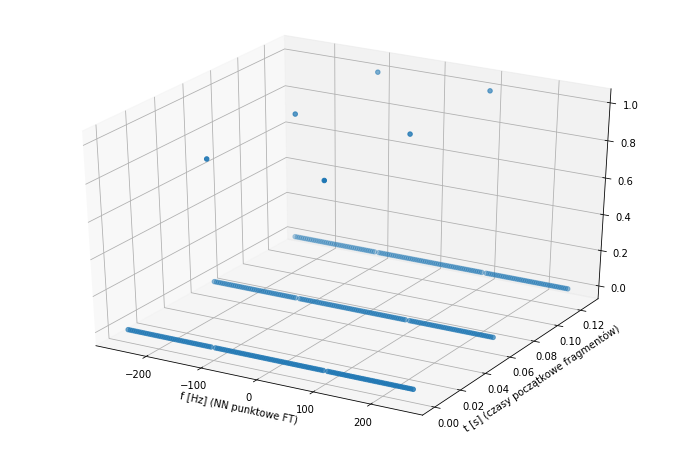

In [92]:
# Uzgodnienie fazy NN-elementowych transformat Fouriera

CHX = [ [ CHX[p][k]*np.exp(-1j*2*np.pi * freq[k] *p*L/samplingFreq) for k in range(NN) ] for p in range(P) ]
CHY = [ [ CHY[p][k]*np.exp(-1j*2*np.pi * freq[k] *p*L/samplingFreq) for k in range(NN) ] for p in range(P) ]

# Ponowna wizualizacja widma
CHX = np.array(CHX)
CHXpsd = [ np.power(2*abs(CHX[k]),2) for k in range(P) ]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:3], Y[:3], CHXpsd[:3])
ax.set_xlabel('f [Hz] (NN punktowe FT)')
ax.set_ylabel('t [s] (czasy początkowe fragmentów)')
fig.set_figwidth(12)
fig.set_figheight(8)

In [93]:
# Wymnożenie współczynników Fouriera
# XY[p,(f[k1],f[k2])] = \overline{X}[p,f[k1]]*Y[p,f[k2]] = \overline{X}[p,k1]*Y[p,k2]
# XY[p,(f[k1],k2)] = XY[NN*k1 + k2][p] - taki rozkład elementów w dwuwymiarowej tablicy 
# pozwala w łatwy sposób zlokalizować punkt określony przez indeksy (p,k1,k2), 
# odpowiadające współrzędnym (p,f1,f2) 

XY = np.zeros((NN*NN,P), dtype = 'complex')

for k1 in range(NN):
    for k2 in range(NN):
        for p in range(P):
            XY[ NN*k1 + k2 ][p] = np.conj(CHX[p][k1]) * CHY[p][k2]

In [96]:
# P-elementowe FFT

# Selekcja punktów o odpowiedniej rozdzielczości częstotliwościowej 
# Zmiana zmiennych z (p,f1,f2) na (f,\alpha)

# q[p]\Delta\alpha = freqP[p] 
freq1 = np.linspace(0, (1/2-1/P) * samplingFreq/L, P/2) # Hz 
freq2 = np.linspace(-1/2 * samplingFreq/L, -1/P*samplingFreq/L, P/2) 
freqP = np.concatenate((freq1,freq2))

# -P*L/2/NN <= q <= P*L/2/NN - 1 daje P*L/NN wartości q, wobec tego tablica danych przyjmuje wymiary:
# (NN)^2 x (P*L/NN)

PP = int(P*L/NN)
XYabs = np.zeros((NN*NN, PP-1))
Xax = np.zeros((NN*NN, PP-1)) # \alpha
Yax = np.zeros((NN*NN, PP-1)) # f

XYabsTemp = np.zeros((NN*NN,P)) # tablica pomocnicza równa, której elementy są równe modułowi tablicy XY
XYF = np.zeros((NN*NN,P), dtype = 'complex')

for k1 in range(NN):
    for k2 in range(NN):
        XYF[ NN*k1 + k2 ] = fft(XY[ NN*k1 + k2 ])/P
        XYabsTemp[ NN*k1 + k2 ] = abs(XYF[ NN*k1 + k2 ])
        for p in range(int(PP/2)):
            Xax[ NN*k1 + k2 ][p] = ( freq[k1] - freq[ k2 ] ) + freqP[p] #+  p/N*samplingFreq  #freqP[p]
            Yax[ NN*k1 + k2 ][p] = (freq[k1]+freq[k2])/2
            XYabs[ NN*k1 + k2 ][p] = XYabsTemp[ NN*k1 + k2 ][p]
            
            Xax[ NN*k1 + k2 ][PP-2-p] = ( freq[k1] - freq[ k2 ] ) + freqP[P-1-p]
            Yax[ NN*k1 + k2 ][PP-2-p] = (freq[k1]+freq[k2])/2
            XYabs[ NN*k1 + k2 ][PP-2-p] = XYabsTemp[ NN*k1 + k2 ][P-1-p]

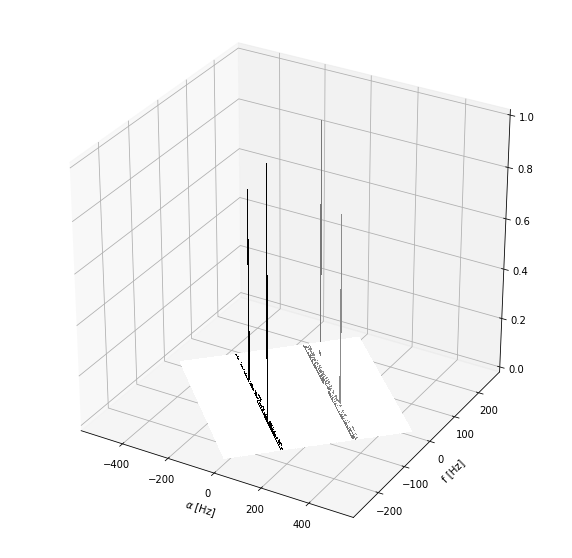

In [97]:
"""Z = 4*XYabs
X=Xax
Y=Yax
fig, ax = plt.subplots()
ax.pcolormesh(X, Y, Z, shading='flat', vmin=0.1, vmax=Z.max())
fig.set_figheight(10)
fig.set_figwidth(10) """

#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
fig = plt.figure()
ax = fig.gca(projection='3d')
pl = ax.plot_surface(Xax, Yax, 4*XYabs, cmap=mpl.binary,
                       linewidth=0, antialiased=False) # , cmap=mpl.coolwarm
ax.set_zlim(0, 1)
#pl.set_cmap('jet')
#ax.set_zlim(0.1, 0.25)
#fig.colorbar(pl)
ax.set_xlabel(r'$\alpha$ [Hz]')
ax.set_ylabel('f [Hz]')
fig.set_figheight(10)
fig.set_figwidth(10)

In [98]:
# wykreślenie przekroju dla f = 0
S = []
XaxS = []
for n in range(NN*NN):
    for p in range(PP-1):
        if Yax[n][p] == 0.0:
            S.append(4*XYabs[n][p])
            XaxS.append(Xax[n][p])

Text(0.5, 1.0, '$f$ = 0 projection')

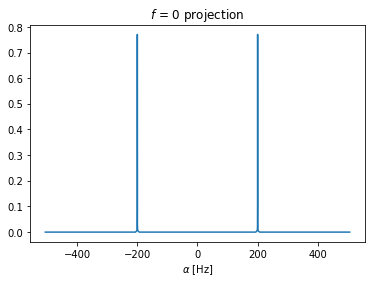

In [99]:
XaxSS, SS = zip(*sorted(zip(XaxS, S))) # sortowanie danych w taki sposób, żeby wartości w XaxSS były rosnące
plt.plot(XaxSS,SS)
plt.xlabel(r'$\alpha$ [Hz]')
plt.title(r'$f$ = 0 projection')
#plt.savefig('SNR=inf_f=0_projection.png')

In [100]:
# wykreślenie przekroju dla alpha = 0
S2 = []
YaxS2 = []
for n in range(NN*NN):
    for p in range(PP-1): #range(P):
        if Xax[n][p] == 0:
            S2.append(4*XYabs[n][p])
            YaxS2.append(Yax[n][p])

Text(0.5, 1.0, '$\\alpha$ = 0 projection')

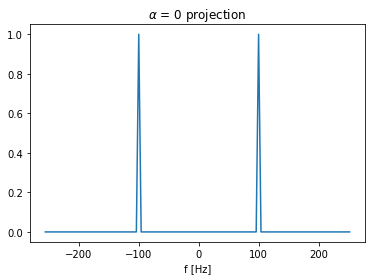

In [101]:
# sortowanie danych
YaxSS2 = np.concatenate((YaxS2[int(len(YaxS2)/2):],YaxS2[:int(len(YaxS2)/2)]))
SS2 = np.concatenate((S2[int(len(YaxS2)/2):],S2[:int(len(YaxS2)/2)]))

plt.plot(YaxSS2,SS2)
plt.xlabel('f [Hz]')
plt.title(r'$\alpha$ = 0 projection')
#plt.savefig('SNR=inf_alpha=0_projection.png')

In [134]:
print(samplingFreq/P/L)
print(P*L/NN)
print(samplingFreq/2/NN)
print(samplingFreq/2/NN/(samplingFreq/P/L))
Xax[1]

0.031496062992125984
127.0
2.0
63.5


array([-4.        , -3.96850394, -3.93700787, -3.90551181, -3.87401575,
       -3.84251969, -3.81102362, -3.77952756, -3.7480315 , -3.71653543,
       -3.68503937, -3.65354331, -3.62204724, -3.59055118, -3.55905512,
       -3.52755906, -3.49606299, -3.46456693, -3.43307087, -3.4015748 ,
       -3.37007874, -3.33858268, -3.30708661, -3.27559055, -3.24409449,
       -3.21259843, -3.18110236, -3.1496063 , -3.11811024, -3.08661417,
       -3.05511811, -3.02362205, -2.99212598, -2.96062992, -2.92913386,
       -2.8976378 , -2.86614173, -2.83464567, -2.80314961, -2.77165354,
       -2.74015748, -2.70866142, -2.67716535, -2.64566929, -2.61417323,
       -2.58267717, -2.5511811 , -2.51968504, -2.48818898, -2.45669291,
       -2.42519685, -2.39370079, -2.36220472, -2.33070866, -2.2992126 ,
       -2.26771654, -2.23622047, -2.20472441, -2.17322835, -2.14173228,
       -2.11023622, -2.07874016, -2.04724409, -5.98425197, -5.95275591,
       -5.92125984, -5.88976378, -5.85826772, -5.82677165, -5.79